In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

from collections import Counter

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers

## Load the data set - 40 subjects, each with 10 pictures

In [2]:
# Extract the zip file
with zipfile.ZipFile('/content/Faces.zip' , 'r') as zip_ref:
    zip_ref.extractall('/content/Faces')

In [3]:
# Set directory to access pictures
face_data = '/content/Faces' 

In [4]:
# Initialize lists to hold image data (flattened for Random Forest and Logistic Regression and original 2D for CNN) and its label
X_data = []
y_data = []
X_data_original = []

In [5]:
# Iterate through dataset directory
for dir_name in os.listdir(face_data):
    if os.path.isdir(os.path.join(face_data, dir_name)):
        label = dir_name
        for img_name in os.listdir(os.path.join(face_data, dir_name)):
            img_path = os.path.join(face_data, dir_name, img_name)
            img = Image.open(img_path).convert('L')  # convert to grayscale
            img_array = np.array(img)
            img_flattened = img_array.flatten() # flatten from 2D array to 1D array
            X_data.append(img_flattened)
            y_data.append(label)
            X_data_original.append(img_array) # keep original 2D array

## Exploratory Data Analysis

### Check a specific subject's image set

In [6]:
# Accessing the data for a specific set of images
set_number = 's7' 
set_images = [img for img, label in zip(X_data, y_data) if label == set_number]

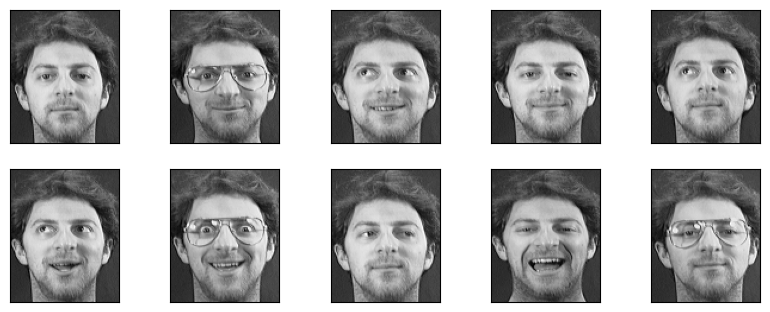

In [7]:
# Print the images from the specified set
plt.figure(figsize=(10, 10))
for i, img in enumerate(set_images):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
plt.show()

### Image Stats

In [8]:
# Initialize a dictionary to hold average pixel intensities for each class
average_pixel_intensities = {}

# Iterate over each class
for class_name in set(y_data):
    # Find all images belonging to this class
    class_images = [image for image, label in zip(X_data, y_data) if label == class_name]
    
    # Calculate average pixel intensity for this class
    average_pixel_intensity = np.mean([np.mean(image) for image in class_images])
    
    # Store the result in our dictionary
    average_pixel_intensities[class_name] = average_pixel_intensity

# Print the results
for class_name, avg_intensity in average_pixel_intensities.items():
    print(f"Average pixel intensity for class {class_name}: {avg_intensity}")

Average pixel intensity for class s22: 85.1676921583851
Average pixel intensity for class s3: 115.87922166149067
Average pixel intensity for class s8: 120.13745147515526
Average pixel intensity for class s21: 101.22831909937888
Average pixel intensity for class s32: 125.42356366459629
Average pixel intensity for class s15: 112.20925854037266
Average pixel intensity for class s23: 111.16773097826088
Average pixel intensity for class s38: 108.30481366459628
Average pixel intensity for class s19: 120.02870729813665
Average pixel intensity for class s12: 121.021525621118
Average pixel intensity for class s10: 104.09259510869565
Average pixel intensity for class s25: 124.24754464285715
Average pixel intensity for class s7: 112.2466323757764
Average pixel intensity for class s37: 109.1043963509317
Average pixel intensity for class s33: 92.42089479813664
Average pixel intensity for class s16: 121.01252911490683
Average pixel intensity for class s9: 113.32507763975157
Average pixel intensity f

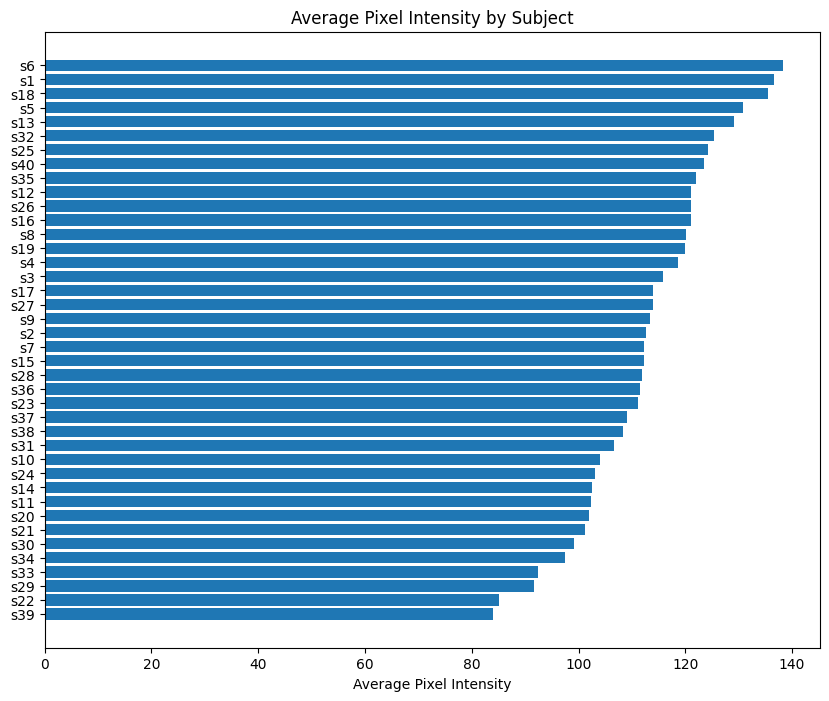

In [9]:
# Create DataFrame from dictionary
average_pixel_intensities_df = pd.DataFrame(list(average_pixel_intensities.items()), columns=['Subject', 'Average Pixel Intensity'])

# Sort DataFrame by 'Average Pixel Intensity'
average_pixel_intensities_df = average_pixel_intensities_df.sort_values('Average Pixel Intensity')

# Plot bar chart
plt.figure(figsize=(10,8))
plt.barh(average_pixel_intensities_df['Subject'], average_pixel_intensities_df['Average Pixel Intensity'])
plt.xlabel('Average Pixel Intensity')
plt.title('Average Pixel Intensity by Subject')
plt.show()

## Random Forest

Inspired by https://notebook.community/mbeyeler/opencv-machine-learning/notebooks/10.03-Using-Random-Forests-for-Face-Recognition

In [10]:
# Training and Testing Split (used for both Random Forest and Logistic Regression)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=21)

In [11]:
model = RandomForestClassifier()

In [12]:
# Fit the Random Forest Classifier on the training data
model.fit(X_train, y_train)

RandomForestClassifier()

In [13]:
# Make predictions on the test set
RF_y_pred = model.predict(X_test)

In [14]:
# Print the balanced_accuracy score of the Random Forest model
RF_balanced_accuracy_score = balanced_accuracy_score(y_test, RF_y_pred)
print(f"Random Forest Balanced Accuracy Score : {RF_balanced_accuracy_score * 100:.2f}%")

Random Forest Balanced Accuracy Score : 96.79%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [15]:
# Generate a confusion matrix for Random Forest model
RFconfusion_matrix = confusion_matrix(y_test, RF_y_pred)
print(f"Logistic Regression Confusion Matrix:") 
print(RFconfusion_matrix)

Logistic Regression Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 3]]


In [16]:
# Evaluate the Random Forest model
print("Random Forest Classification Report: \n", classification_report(y_test, RF_y_pred))


Random Forest Classification Report: 
               precision    recall  f1-score   support

          s1       1.00      0.75      0.86         4
         s10       1.00      1.00      1.00         4
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         2
         s13       1.00      1.00      1.00         4
         s14       1.00      1.00      1.00         3
         s15       1.00      1.00      1.00         2
         s16       1.00      0.75      0.86         4
         s17       1.00      1.00      1.00         1
         s18       1.00      1.00      1.00         4
         s19       1.00      1.00      1.00         2
          s2       1.00      1.00      1.00         3
         s20       1.00      1.00      1.00         3
         s21       0.50      1.00      0.67         1
         s22       1.00      1.00      1.00         3
         s23       1.00      1.00      1.00         3
         s24       0.00      0.00      0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Exploration of Results for Random Forest

In [17]:
# Finding Misclassified images in Random Forest

# Convert y_test and RF_y_pred to numpy arrays
y_test_array = np.array(y_test)
RF_y_pred_array = np.array(RF_y_pred)

# Find indices of misclassified examples
RFmisclassified = np.where(y_test_array != RF_y_pred_array)[0]

# Create dataframe of misclassified examples
RFmisclassified_df = pd.DataFrame({
    'True Label': y_test_array[RFmisclassified],
    'Predicted Label': RF_y_pred_array[RFmisclassified]
})

RFmisclassified_df

,True Label,Predicted Label
0,s16,s24
1,s3,s26
2,s1,s24
3,s36,s7
4,s33,s21


In [18]:
# Inspecting the distribution of training and test sets (used in both Random Forest and Logistic Regression)

# Count occurrences of each label in the training set
train_label_counts = Counter(y_train)

# Count occurrences of each label in the test set
test_label_counts = Counter(y_test)

# Display the counts
print("Training label counts:", train_label_counts)
print("Test label counts:", test_label_counts)

Training label counts: Counter({'s24': 10, 's21': 9, 's39': 9, 's17': 9, 's37': 9, 's28': 9, 's25': 9, 's31': 9, 's11': 8, 's19': 8, 's34': 8, 's32': 8, 's35': 8, 's15': 8, 's5': 8, 's6': 8, 's8': 8, 's12': 8, 's40': 8, 's26': 8, 's7': 8, 's23': 7, 's2': 7, 's20': 7, 's14': 7, 's22': 7, 's9': 7, 's30': 7, 's27': 7, 's38': 7, 's36': 6, 's4': 6, 's18': 6, 's3': 6, 's13': 6, 's16': 6, 's10': 6, 's1': 6, 's29': 6, 's33': 6})
Test label counts: Counter({'s18': 4, 's16': 4, 's13': 4, 's3': 4, 's4': 4, 's1': 4, 's10': 4, 's36': 4, 's29': 4, 's33': 4, 's27': 3, 's30': 3, 's2': 3, 's23': 3, 's22': 3, 's14': 3, 's9': 3, 's20': 3, 's38': 3, 's6': 2, 's26': 2, 's12': 2, 's19': 2, 's34': 2, 's32': 2, 's15': 2, 's8': 2, 's11': 2, 's35': 2, 's40': 2, 's7': 2, 's5': 2, 's17': 1, 's37': 1, 's31': 1, 's21': 1, 's28': 1, 's25': 1, 's39': 1})


## Visualizations for Random Forest

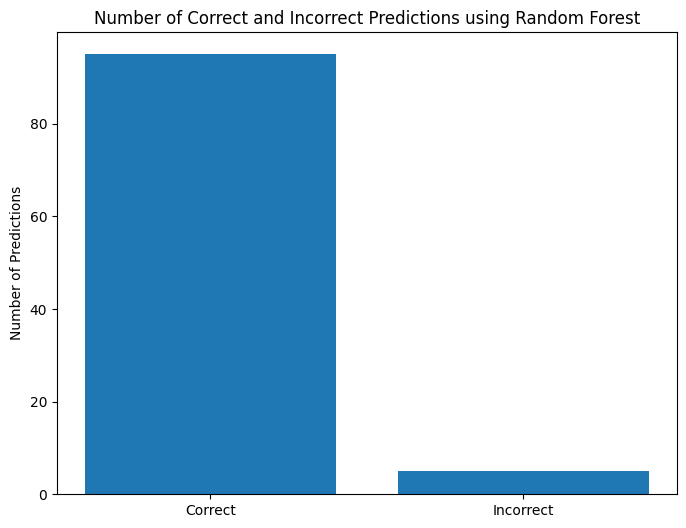

In [19]:
# Calculate number of correct and incorrect predictions
correct_predictions = sum(y_test_array == RF_y_pred_array)
incorrect_predictions = sum(y_test_array != RF_y_pred_array)

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(["Correct", "Incorrect"], [correct_predictions, incorrect_predictions])
plt.ylabel("Number of Predictions")
plt.title("Number of Correct and Incorrect Predictions using Random Forest")
plt.show()

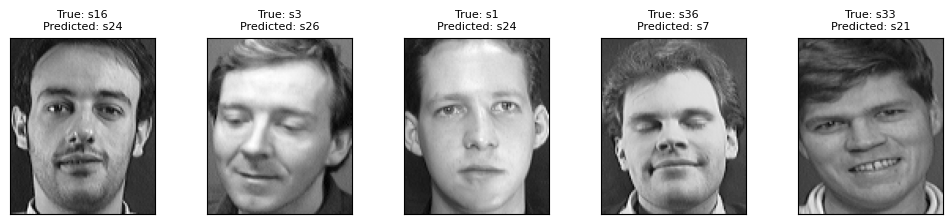

In [20]:
# Display misclassified images along with text indicating True and Predicted subjects for Random Forest

# Iterate through misclassified images and display the corresponding images
plt.figure(figsize=(10, 10))
for i, index in enumerate(RFmisclassified):
    img = X_test[index]
    true_label = y_test_array[index]
    pred_label = RF_y_pred_array[index]
    
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
    plt.title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=8)

plt.tight_layout()
plt.show()

##Logistic Regression

In [21]:
# Assign a random_state parameter of 1 to the model
LRmodel = LogisticRegression(random_state=1)

# Fit the model using training data
LRmodel.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

In [22]:
# Make a prediction using the testing data
LR_y_pred = LRmodel.predict(X_test)

In [23]:
# Print the balanced_accuracy score of the model
LR_balanced_accuracy_score = balanced_accuracy_score(y_test, LR_y_pred)
print(f"Logistic Regression Balanced Accuracy Score : {LR_balanced_accuracy_score * 100:.2f}%")

Logistic Regression Balanced Accuracy Score : 97.22%


In [24]:
# Generate a confusion matrix for Logistic Regression model
LRconfusion_matrix = confusion_matrix(y_test, LR_y_pred)
print(f"Logistic Regression Confusion Matrix:") 
print(LRconfusion_matrix)

Logistic Regression Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 3 0 ... 0 1 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 3]]


In [25]:
# Print the classification report for the model
LRclassification_report = classification_report(y_test, LR_y_pred)
print(f"Logistic Regression Classification Report:")
print(LRclassification_report)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          s1       1.00      0.75      0.86         4
         s10       1.00      0.75      0.86         4
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         2
         s13       1.00      1.00      1.00         4
         s14       1.00      1.00      1.00         3
         s15       1.00      1.00      1.00         2
         s16       0.80      1.00      0.89         4
         s17       1.00      1.00      1.00         1
         s18       1.00      1.00      1.00         4
         s19       1.00      1.00      1.00         2
          s2       1.00      1.00      1.00         3
         s20       1.00      0.67      0.80         3
         s21       0.50      1.00      0.67         1
         s22       1.00      1.00      1.00         3
         s23       1.00      1.00      1.00         3
         s25       1.00      1.00     

## Exploration of Results for Logistic Regression

In [26]:
# Finding Misclassified images in Logistic Regression

# Convert y_test and LR_y_pred to numpy arrays
y_test_array = np.array(y_test)
LR_y_pred_array = np.array(LR_y_pred)

# Find indices of misclassified examples
LRmisclassified = np.where(y_test_array != LR_y_pred_array)[0]

# Create dataframe of misclassified examples
LRmisclassified_df = pd.DataFrame({
    'True Label': y_test_array[LRmisclassified],
    'Predicted Label': LR_y_pred_array[LRmisclassified]
})

LRmisclassified_df


,True Label,Predicted Label
0,s1,s16
1,s33,s21
2,s20,s29
3,s10,s8


## Visualizations for Logistic Regression

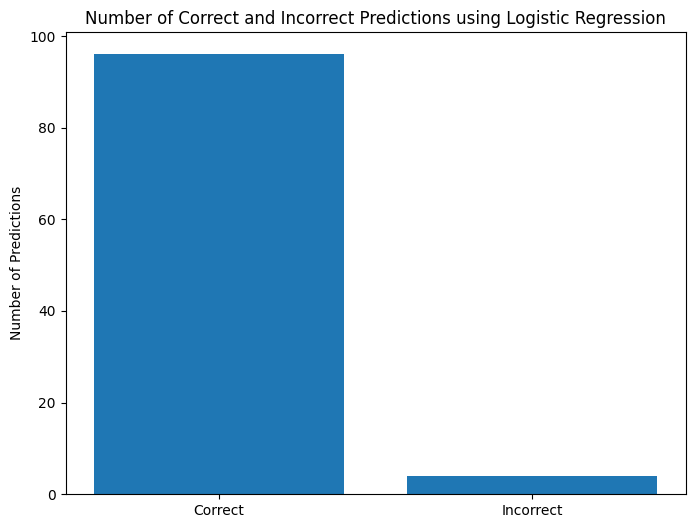

In [27]:
# Calculate number of correct and incorrect predictions
correct_predictions = sum(y_test_array == LR_y_pred_array)
incorrect_predictions = sum(y_test_array != LR_y_pred_array)

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(["Correct", "Incorrect"], [correct_predictions, incorrect_predictions])
plt.ylabel("Number of Predictions")
plt.title("Number of Correct and Incorrect Predictions using Logistic Regression")
plt.show()

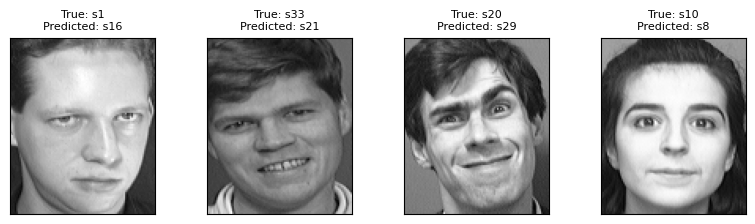

In [28]:
# Display misclassified images along with text indicating True and Predicted subjects for Logistic Regression

# Iterate through misclassified indices and display the corresponding images
plt.figure(figsize=(10, 10))
for i, index in enumerate(LRmisclassified):
    img = X_test[index]
    true_label = y_test_array[index]
    pred_label = LR_y_pred[index]
    
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
    plt.title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=8)

plt.tight_layout()
plt.show()


## CNN - work in progress
Inspired by https://selectstar-ai.medium.com/what-is-mnist-and-why-is-it-important-e9a269edbad5

In [29]:
# Create numpy array
X_data_original = np.array(X_data_original)
y_data = np.array(y_data)

# Split the original image data into training and testing sets
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_data_original, y_data, test_size=0.2, random_state=21)

print('Original Images:')
print('X_train_original = %s, y_train_original = %s' % (X_train_original.shape, y_train_original.shape))
print('X_test_original = %s, y_test_original = %s' % (X_test_original.shape, y_test_original.shape))

Original Images:
X_train_original = (320, 112, 92), y_train_original = (320,)
X_test_original = (80, 112, 92), y_test_original = (80,)


In [30]:
# Reshaping the array to become 4-dimensional
X_train_original  = X_train_original.reshape(X_train_original.shape[0], 112, 92, 1)
X_test_original = X_test_original.reshape(X_test_original.shape[0], 112, 92, 1)

print('After reshaping, X_train_original is :', X_train_original.shape)
print('X_train_original contains', X_train_original.shape[0], "images")
print('X_test_original contains', X_test_original.shape[0], "images")

After reshaping, X_train_original is : (320, 112, 92, 1)
X_train_original contains 320 images
X_test_original contains 80 images


In [31]:
# To ensure decimal points after division
X_train_original = X_train_original.astype('float32')
X_test_original = X_test_original.astype('float32')

# Normalizing the RGB codes by dividing it by the max RGB value
X_train_original /= 255
X_test_original /= 255

In [32]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_original)
y_test_encoded = label_encoder.transform(y_test_original)

In [33]:
# One-hot encode the target labels
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

In [34]:
# Creating a  sequential model named and adding layers to it
network = models.Sequential()
network.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Flatten())
network.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
network.add(layers.Dense(40, activation='softmax'))

In [35]:
# Compile the model
network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Fit the model
history = network.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=10)

# Evaluate the model on the test set
test_loss, test_accuracy = network.evaluate(X_test_original, y_test_encoded)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
8/8 [==============================] - 4s 373ms/step - loss: 15.7133 - accuracy: 0.0312 - val_loss: 9.2496 - val_accuracy: 0.0156
Epoch 2/10
8/8 [==============================] - 4s 463ms/step - loss: 5.6421 - accuracy: 0.0391 - val_loss: 3.9399 - val_accuracy: 0.0469
Epoch 3/10
8/8 [==============================] - 3s 314ms/step - loss: 3.5070 - accuracy: 0.0469 - val_loss: 3.6563 - val_accuracy: 0.0469
Epoch 4/10
8/8 [==============================] - 2s 300ms/step - loss: 3.4568 - accuracy: 0.0703 - val_loss: 3.7060 - val_accuracy: 0.0469
Epoch 5/10
8/8 [==============================] - 3s 325ms/step - loss: 3.3805 - accuracy: 0.0664 - val_loss: 3.5083 - val_accuracy: 0.0469
Epoch 6/10
8/8 [==============================] - 2s 301ms/step - loss: 3.2305 - accuracy: 0.0977 - val_loss: 3.4574 - val_accuracy: 0.1094
Epoch 7/10
8/8 [==============================] - 4s 491ms/step - loss: 3.0966 - accuracy: 0.1289 - val_loss: 3.5334 - val_accuracy: 0.0625
Epoch 8/10
8/8 [===

## Exploration of Results for CNN

## Visualizations for CNN